# Convolutional Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

sns.set()
sns.set_style('white')

Layers in a ConvNet:
- Convolutional layer
- MaxPooling layer
- Fully connected layer

## mnist digits

In [2]:
# load mnist of handwritten digits data
(x_train, y_train), (x_test,y_test) = mnist.load_data()

# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')/255.0
x_test  = x_test.astype('float32')/255.0

y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

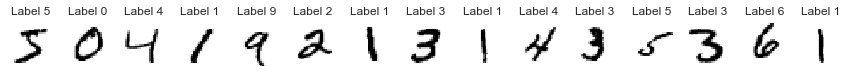

In [3]:
n_ex = 15
plt.figure(figsize=(n_ex,1))

for i in range(n_ex):
    plt.subplot(1,n_ex,i+1)
    plt.imshow(x_train[i,:,:],cmap=plt.cm.gray_r)
    plt.title('Label {}'.format(y_train[i]))
    plt.grid(False)
    plt.axis('off')
plt.show()

In [4]:
xavier = tf.initializers.GlorotNormal()
w_conv = tf.Variable(xavier(shape=(3,3,1,10)))
b_conv = tf.Variable(tf.zeros((1,1,1,10)))

w_dens = tf.Variable(xavier(shape=(1690,10)))
b_dens = tf.Variable(tf.zeros((1,10)))
variables = [w_conv,w_dens,b_dens]

def forward_model(x):
    
    x_ = tf.expand_dims(x,axis=-1)
    
    z_conv = tf.nn.conv2d(x_,w_conv,strides=1,padding='VALID') + b_conv
    a_conv = tf.nn.relu(z_conv)
    #print(a_conv.shape)
    a_pool = tf.nn.max_pool(a_conv, ksize = (1,2,2,1), strides = (1,2,2,1), padding='VALID')
    #print(a_pool.shape)
    a_flat = tf.reshape(a_pool,(a_pool.shape[0],-1))
    #print(a_flat.shape)
    
    z_dens = tf.matmul(a_flat,w_dens) + b_dens
    #print(z_dens.shape)
    
    return z_dens

def compute_loss(y,z):
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=z,labels=y))
    return loss

def compute_acc(y,z):
    a= tf.nn.softmax(z)
    y_pred = tf.argmax(a, axis=1,output_type=tf.int64)
    acc = tf.reduce_mean(tf.cast(tf.equal(y_pred,y),tf.float32))

    return acc


optimizer = tf.optimizers.Adam(learning_rate=0.01)

@tf.function
def train_batch(x,y):
    with tf.GradientTape() as tape:        
        z = forward_model(x)
        loss = compute_loss(y,z)
        grads = tape.gradient(loss,variables)
        optimizer.apply_gradients(zip(grads,variables))
        
        acc = compute_acc(y,z)
    return loss,acc

In [5]:
z = forward_model(x_train[:100,:,:])
init_loss = compute_loss(y_train[:100],z)
print('initial loss = %.4f' % init_loss)

t1 = time.time()
n_epoch = 1
for i in range(n_epoch):
    
    for j in range(600):
        k = np.arange(100*(j-1),100*j,1,np.int)
        x_train_batch = x_train[k,:,:]
        y_train_batch = y_train[k]
        
        current_loss,current_acc = train_batch(x_train_batch,y_train_batch)
    print('loss after %d epoch = %.4f, acc = %.4f' % (i+1, current_loss, current_acc))
t2 = time.time()
print(t2-t1)

initial loss = 2.3584
loss after 1 epoch = 0.0202, acc = 0.9900
47.19469690322876


### Keras framework


In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(10, kernel_size=(3,3), input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1690)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                16910     
Total params: 17,010
Trainable params: 17,010
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.fit(x_train[:,:,:,np.newaxis],y_train, epochs=1, batch_size=100)

Train on 60000 samples
60000/60000 [==============================] - 46s 765us/sample - loss: 0.2286 - accuracy: 0.9323


### What does CNN do/see?

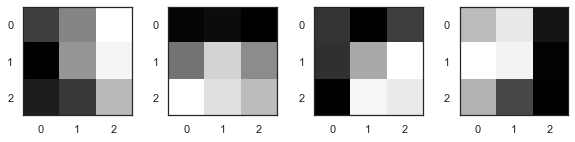

In [10]:
# plot the the weights of the first layer to show edge detection effect
# https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/
plt.figure(figsize=[10,2])
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.gray()
    plt.imshow(w_conv[:,:,0,i])
plt.show() 

Representation of CNNs

<img src="cnn_representation.jpeg" width="600" />